# Plot F-layer figures

This notebook makes the final two figures form the manuscript and part of the first figure. It does this by processing output files from a large batch of runs.

In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import plotting

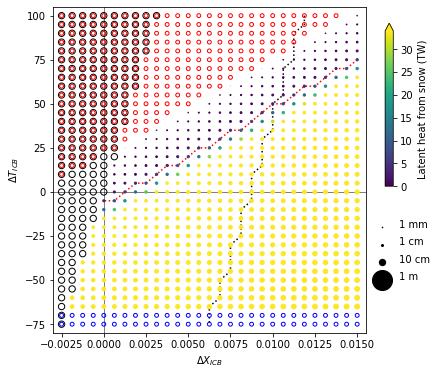

In [2]:
target_density_excess = 27.24 # This is prem - ak135f
target_latent_heat = 6.0*1.0E12 # W 

summary_file = pathlib.Path('/Users/andreww/Desktop/new_slurry_cases/tx_grid/grid.csv')
summary_df = pd.read_csv(summary_file)
plotting.plot_summary_figure(summary_df, target_latent_heat=target_latent_heat, 
                    target_density_excess=target_density_excess)

## Plot the (input) temperature and composition profiles 

This *should* be the optimum location, but currently do not get access to this.

/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)
/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)


BV freq = 0.00022590837386311853
Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2


/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


Temperature at CMB: 1565.182533320388 K
Liquid density at ICB: 12792.534318523183 Kg/m^3
Liquid density at top of F-layer 12542.509302676566 Kg/m^3
Liquid density along adiabat at ICB: 12764.931169768386 Kg/m^3
Liquid density along adiabat at top of F-layer 12571.912798104033 Kg/m^3
Liquid density difference at ICB: 27.603148754797076 Kg/m^3


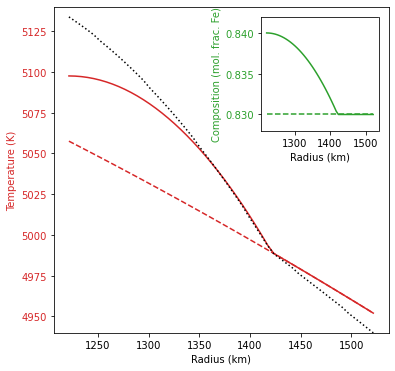

In [3]:
plotting.make_layer_plot(40, 0.01, 0.83)